In [1]:
import pandas as pd
import csv

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt

import collections
from collections import defaultdict

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
df = pd.read_csv("/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/SICK/SICK.txt", sep='\t')


In [23]:
df

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_dataset,sentence_B_dataset,SemEval_set,sentA_length,sentB_length
0,1,A group of kids is playing in a yard and an old man is standing in the background,A group of boys in a yard is playing and a man is standing in the background,NEUTRAL,4.5,A_neutral_B,B_neutral_A,FLICKR,FLICKR,TRAIN,81,76
1,2,A group of children is playing in the house and there is no man standing in the background,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,FLICKR,FLICKR,TRAIN,90,81
2,3,The young boys are playing outdoors and the man is smiling nearby,The kids are playing outdoors near a man with a smile,ENTAILMENT,4.7,A_entails_B,B_entails_A,FLICKR,FLICKR,TRAIN,65,53
3,4,The young boys are playing outdoors and the man is smiling nearby,There is no boy playing outdoors and there is no man smiling,CONTRADICTION,3.6,A_contradicts_B,B_contradicts_A,FLICKR,FLICKR,TRIAL,65,60
4,5,The kids are playing outdoors near a man with a smile,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,3.4,A_neutral_B,B_neutral_A,FLICKR,FLICKR,TRAIN,53,81
...,...,...,...,...,...,...,...,...,...,...,...,...
9835,9996,A man is in a parking lot and is playing tennis against a large wall,The snowboarder is leaping fearlessly over white snow,NEUTRAL,1.0,A_neutral_B,B_neutral_A,FLICKR,FLICKR,TEST,68,53
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,1.0,A_neutral_B,B_neutral_A,SEMEVAL,SEMEVAL,TRAIN,32,32
9837,9998,The man is singing heartily and playing the guitar,A bicyclist is holding a bike over his head in a group of people,NEUTRAL,1.0,A_neutral_B,B_neutral_A,SEMEVAL,FLICKR,TRAIN,50,64
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,1.2,A_neutral_B,B_neutral_A,SEMEVAL,FLICKR,TRAIN,43,29


In [13]:
pd.options.display.max_colwidth=200

In [16]:
df["sentA_length"]= df["sentence_A"].str.len()
df["sentB_length"]= df["sentence_B"].str.len()

In [20]:
df=df.drop('sentence_B_original', axis=1)

### Grouping, size and shapes

In [28]:
df.shape

(9840, 12)

In [22]:
df.groupby('entailment_label').size().sort_values(ascending=False)

entailment_label
NEUTRAL          5595
ENTAILMENT       2821
CONTRADICTION    1424
dtype: int64

In [24]:
df.groupby('sentence_A_dataset').size().sort_values(ascending=False)

sentence_A_dataset
FLICKR     4979
SEMEVAL    4861
dtype: int64

In [25]:
df.groupby('sentence_B_dataset').size().sort_values(ascending=False)

sentence_B_dataset
FLICKR     5052
SEMEVAL    4788
dtype: int64

In [26]:
df.groupby('SemEval_set').size().sort_values(ascending=False)

SemEval_set
TEST     4906
TRAIN    4439
TRIAL     495
dtype: int64

In [29]:
df.groupby('entailment_label')['sentA_length'].mean().sort_values(ascending=False)

entailment_label
ENTAILMENT       47.674229
NEUTRAL          47.016801
CONTRADICTION    43.728933
Name: sentA_length, dtype: float64

In [30]:
df.groupby('sentence_A_dataset')['sentA_length'].mean().sort_values(ascending=False)

sentence_A_dataset
FLICKR     57.059851
SEMEVAL    36.148323
Name: sentA_length, dtype: float64

In [31]:
df.groupby('SemEval_set')['sentA_length'].mean().sort_values(ascending=False)

SemEval_set
TRIAL    48.240404
TRAIN    46.760757
TEST     46.548716
Name: sentA_length, dtype: float64

### Plot length of sentences

In [38]:
def hist_length(df):
    
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentA_length', hue='entailment_label')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentB_length', hue='entailment_label')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentA_length', hue='SemEval_set')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sentB_length', hue='SemEval_set')
    
    print('\n Average lenght of sentences_A :', df["sentA_length"].mean(), '\n' )
    print('Average length of sentences_A per entailment_label: \n',  df.groupby('entailment_label')['sentA_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_A per SemEval_set: \n',  df.groupby('SemEval_set')['sentA_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_A per sentence_A_dataset: \n',  df.groupby('sentence_A_dataset')['sentA_length'].mean().sort_values(ascending=False), '\n')
    
    print('\n Average lenght of sentences_B :', df["sentB_length"].mean(), '\n')
    print('Average length of sentences_B per entailment_label: \n',  df.groupby('entailment_label')['sentB_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_B per SemEval_set: \n',  df.groupby('SemEval_set')['sentB_length'].mean().sort_values(ascending=False), '\n')
    print('Average length of sentences_B per sentence_B_dataset: \n',  df.groupby('sentence_B_dataset')['sentB_length'].mean().sort_values(ascending=False), '\n')
    


 Average lenght of sentences_A : 46.729471544715445 

Average length of sentences_A per entailment_label: 
 entailment_label
ENTAILMENT       47.674229
NEUTRAL          47.016801
CONTRADICTION    43.728933
Name: sentA_length, dtype: float64 

Average length of sentences_A per SemEval_set: 
 SemEval_set
TRIAL    48.240404
TRAIN    46.760757
TEST     46.548716
Name: sentA_length, dtype: float64 

Average length of sentences_A per sentence_A_dataset: 
 sentence_A_dataset
FLICKR     57.059851
SEMEVAL    36.148323
Name: sentA_length, dtype: float64 


 Average lenght of sentences_B : 45.75782520325203 

Average length of sentences_B per entailment_label: 
 entailment_label
NEUTRAL          47.368543
CONTRADICTION    44.144663
ENTAILMENT       43.377526
Name: sentB_length, dtype: float64 

Average length of sentences_B per SemEval_set: 
 SemEval_set
TRIAL    45.898990
TEST     45.819405
TRAIN    45.674026
Name: sentB_length, dtype: float64 

Average length of sentences_B per sentence_B_data

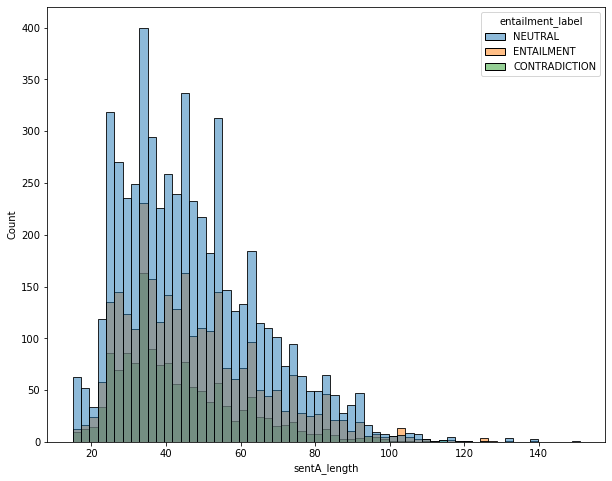

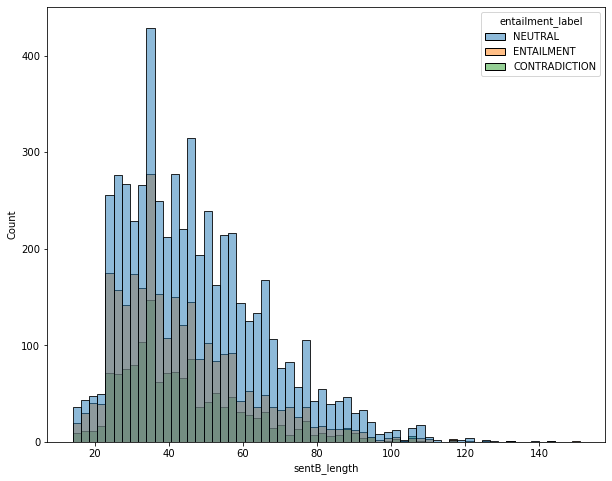

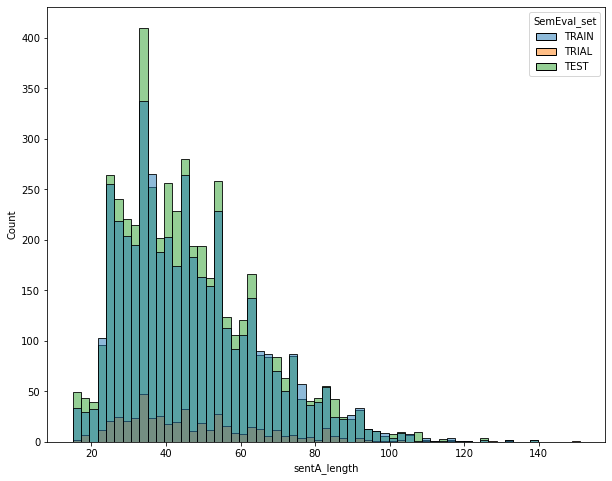

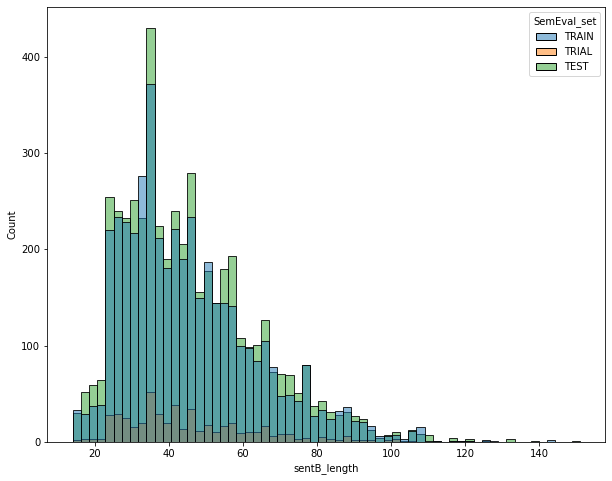

In [39]:
hist_length(df)

### Analyzing word type

In [40]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def stop_words_normal_words(df, sentence):
    corpus=[]

    sentences= df[sentence].str.split()
    words=sentences.values.tolist()
    corpus=[word for i in words for word in i]

    dict_stop_word_count=defaultdict(int)
    for word in corpus:
        if word in stop_words:
            dict_stop_word_count[word]+=1 
            
    stop_words_list=list(dict_stop_word_count.keys())
    count_stop_words_list=list(dict_stop_word_count.values())
    
    plt.figure(figsize=(25,20))         
    sns.barplot( count_stop_words_list, stop_words_list).set_title('Stop words frequency')
    
    print('The total length of our vocab is:', len(stop_words_list))
    
    ##stop_words
    counter=collections.Counter(corpus)
    most_common_words=counter.most_common()
    
    word_list=[]
    count_word_list = []
    
    for word,count in most_common_words[:150]:
        if (word not in stop_words):
            word_list.append(word)
            count_word_list.append(count)
        
    plt.figure(figsize=(20,18))        
    sns.barplot( count_word_list, word_list).set_title('Words frequency')
    
    print('The total sum of stop words is:', len(word_list))

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The total length of our vocab is: 73
The total sum of stop words is: 114


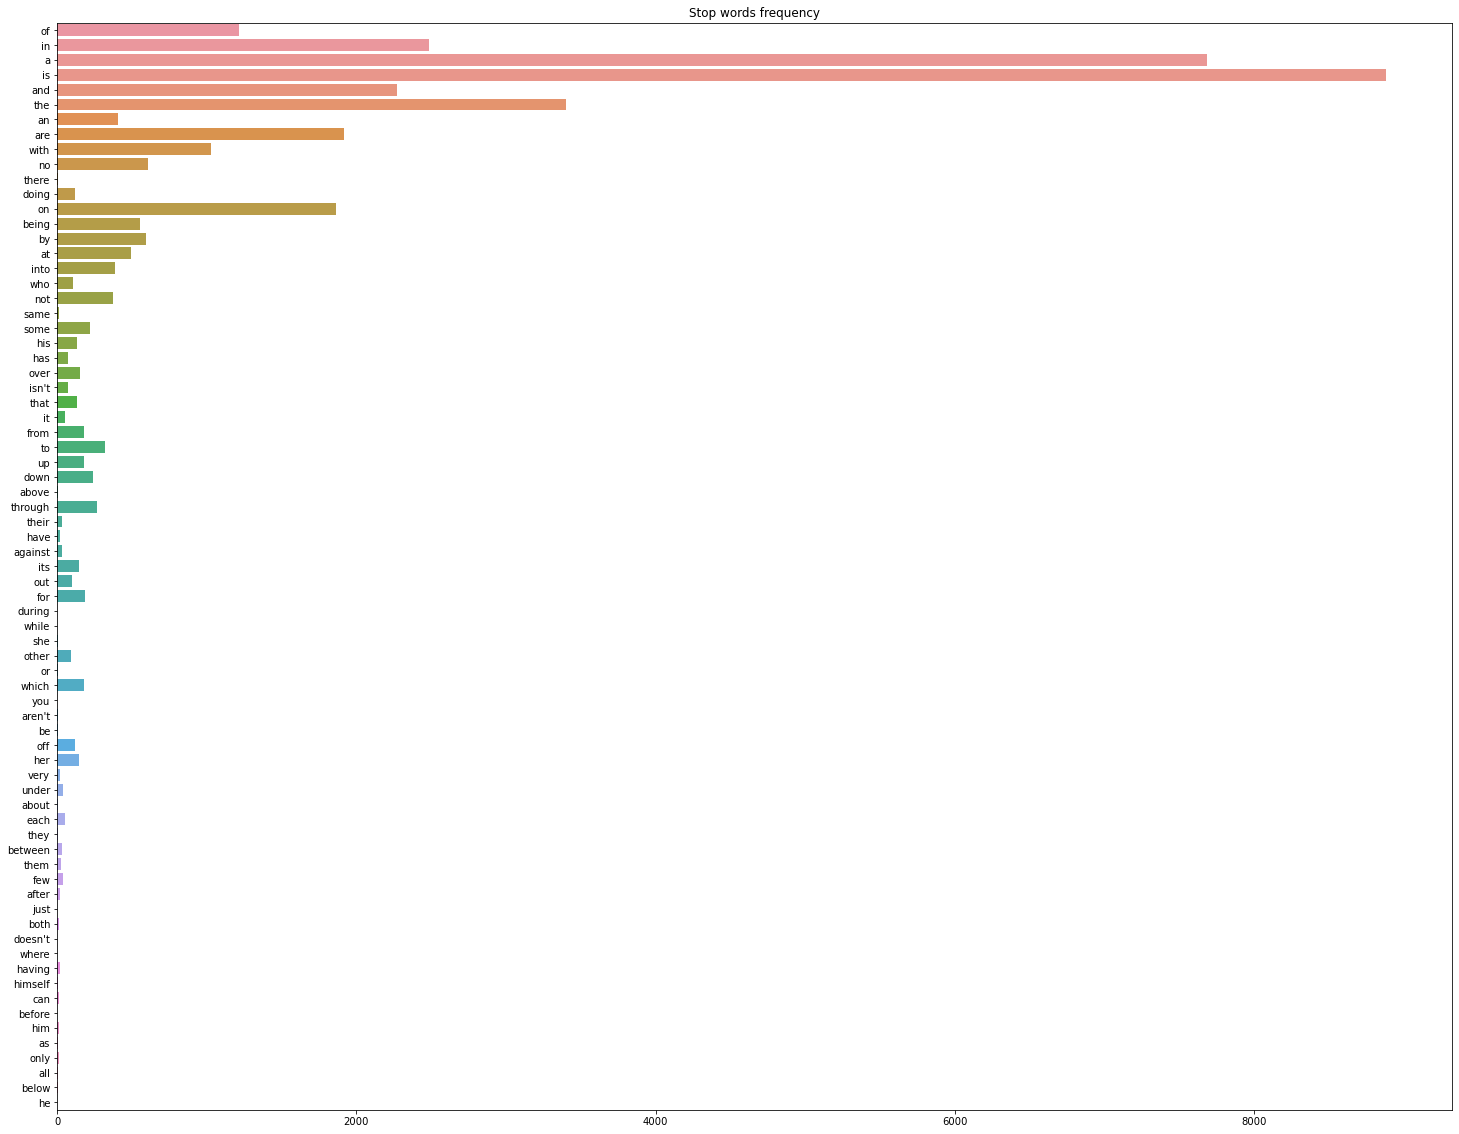

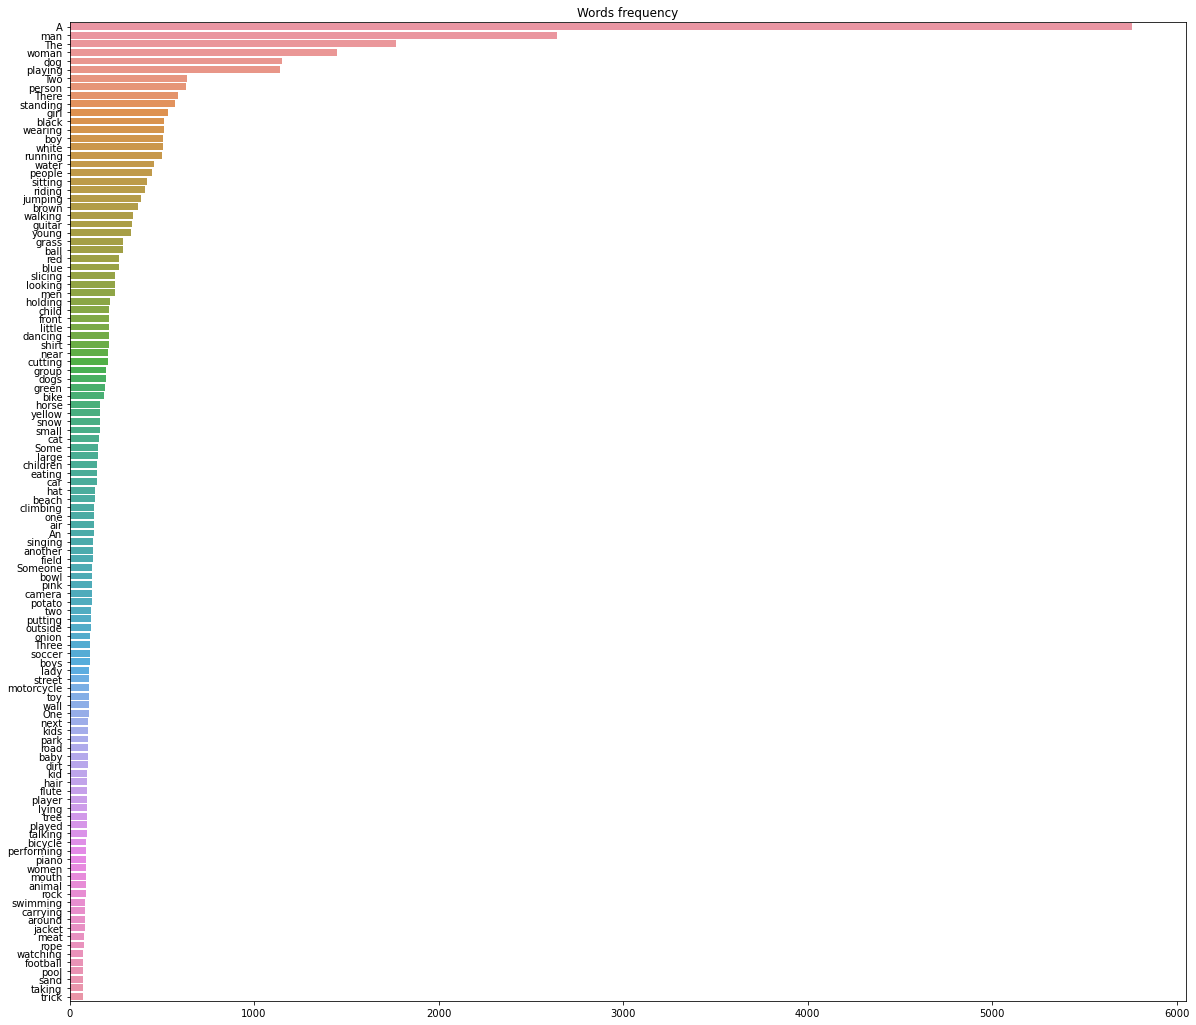

In [43]:
stop_words_normal_words(df, 'sentence_B')

### N-gram analysis

In [44]:
def get_top_pair_words(data, n):
    vec = CountVectorizer(ngram_range=(n, n)).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(20,18))  
    word,count=map(list,zip(*words_freq[0:20]))
    g=sns.barplot(count, word).set_title('Two pair words frequency')
   


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


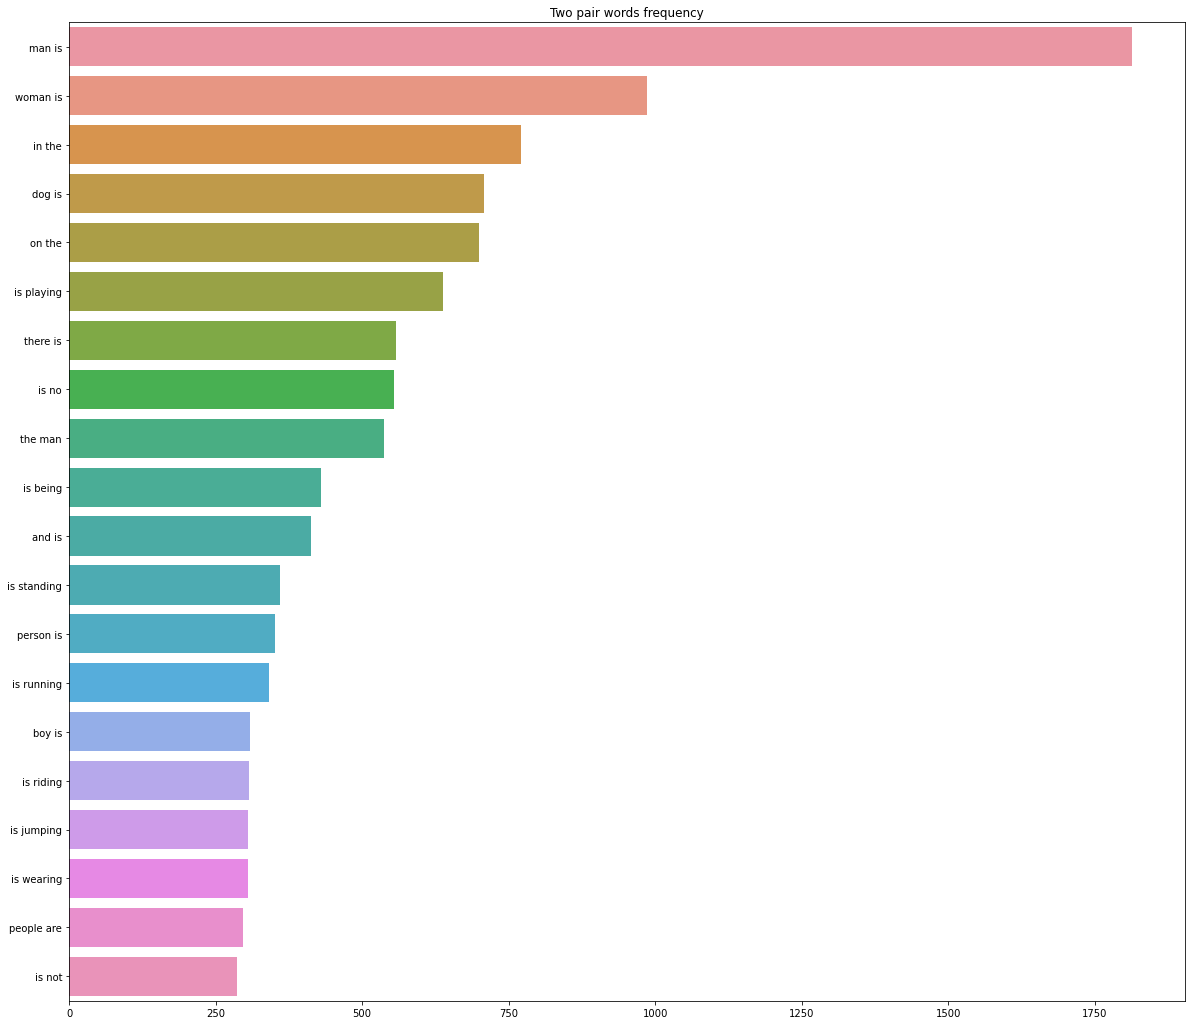

In [45]:
get_top_pair_words(df['sentence_A'], 2)



### Word cloud

In [46]:
def get_word_cloud(data):
    stop_words = nltk.corpus.stopwords.words("english")
    
    word_cloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    word_cloud=word_cloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()



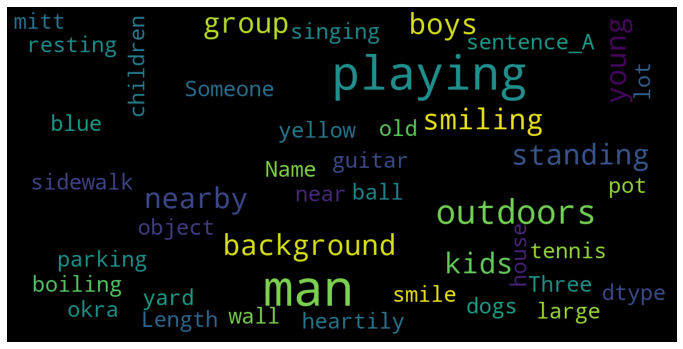

In [48]:
get_word_cloud(df['sentence_A'])

### LDA topic classification

In [49]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
def get_lda_topics(df, sentence):
    text=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    
    for sentence in df[sentence]:
        words=[w for w in word_tokenize(sentence) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        text.append(words)
        
    dict_text_gensim=gensim.corpora.Dictionary(text)
    bow_corpus = [dict_text_gensim.doc2bow(list_words) for list_words in text]
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 9, 
                                   id2word = dict_text_gensim,
                                   workers = 2)
    lda_model.show_topics()   
    
    return lda_model.show_topics(), lda_model,bow_corpus, dict_text_gensim

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
param= get_lda_topics(df, 'sentence_A')

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
param[0]

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.080*"man" + 0.050*"dog" + 0.044*"playing" + 0.027*"The" + 0.023*"guitar" + 0.020*"woman" + 0.017*"sitting" + 0.014*"Two" + 0.012*"running" + 0.011*"water"'),
 (1,
  '0.064*"man" + 0.025*"standing" + 0.025*"The" + 0.024*"woman" + 0.023*"black" + 0.021*"sitting" + 0.018*"dog" + 0.017*"white" + 0.017*"water" + 0.015*"playing"'),
 (2,
  '0.029*"black" + 0.025*"The" + 0.022*"man" + 0.019*"people" + 0.019*"person" + 0.017*"riding" + 0.017*"There" + 0.017*"boy" + 0.015*"water" + 0.015*"woman"'),
 (3,
  '0.058*"man" + 0.057*"woman" + 0.039*"The" + 0.026*"dog" + 0.020*"standing" + 0.018*"playing" + 0.015*"wearing" + 0.012*"brown" + 0.011*"blue" + 0.011*"riding"'),
 (4,
  '0.029*"boy" + 0.029*"walking" + 0.025*"man" + 0.025*"dog" + 0.019*"water" + 0.018*"The" + 0.013*"person" + 0.013*"girl" + 0.012*"street" + 0.012*"jumping"'),
 (5,
  '0.078*"dog" + 0.035*"white" + 0.032*"black" + 0.031*"running" + 0.030*"man" + 0.024*"woman" + 0.023*"brown" + 0.017*"The" + 0.013*"person" + 0.012*"Two"

In [57]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [67]:
lda_model=param[1]
bow_corpus=param[2]
dict_text_gensim=param[3]


vis = gensimvis.prepare(lda_model, bow_corpus, dict_text_gensim)
vis

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.030488 -0.045447       1        1  14.660141
0     -0.059874 -0.041648       2        1  13.507457
5     -0.098516  0.039450       3        1  13.253483
6      0.088877 -0.068957       4        1  11.036445
7      0.050171 -0.031494       5        1  10.913854
1     -0.034478 -0.041674       6        1   9.706359
4      0.038072  0.097974       7        1   9.387285
8     -0.008757  0.039199       8        1   9.090131
2      0.054993  0.052595       9        1   8.444845, topic_info=        Term         Freq        Total Category  logprob  loglift
23       dog  1597.000000  1597.000000  Default  30.0000  30.0000
31     black   691.000000   691.000000  Default  29.0000  29.0000
218   guitar   211.000000   211.000000  Default  28.0000  28.0000
3        man  2143.000000  2143.000000  Default  27.0000  27.0000
167    white   604.000000   604.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
27       Two    30.891082   677.517319   Topic9  -4.9458  -0.6164
70   sitting    28.370909   480.390311   Topic9  -5.0309  -0.3576
69   jumping    27.933576   457.908804   Topic9  -5.0464  -0.3252
65       red    26.328495   333.159976   Topic9  -5.1056  -0.0664
123    grass    26.167469   315.276600   Topic9  -5.1117  -0.0173

[699 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1803      5  0.129347    ATVs
1803      6  0.517389    ATVs
1803      7  0.129347    ATVs
1803      9  0.129347    ATVs
1844      2  0.207185  Adults
...     ...       ...     ...
15        5  0.117067   young
15        6  0.139484   young
15        7  0.037362   young
15        8  0.209225   young
15        9  0.089668   young

[1880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 7, 8, 2, 5, 9, 3])

In [68]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re

final_cleaned_words = []

for index, sentence in df['sentence_A'].items(): 
    alpha_char = re.sub(r'^@\w+',' ', sentence)
    tokens = word_tokenize(alpha_char)
    # convert to lower case
    lowercase_tokens = [word.lower() for word in tokens]
    punct_table = str.maketrans('', '', string.punctuation)
    word_no_punctuation = [word.translate(punct_table) for word in lowercase_tokens]
    # remove remaining tokens that are not alphabetic
    alpha_words = [word for word in word_no_punctuation if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in alpha_words if not word in stop_words]
    final_cleaned_words.append(cleaned_words)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
final_cleaned_words_list = []
for words_list in final_cleaned_words:
    str1 =' '.join(words_list)
    final_cleaned_words_list.append(str1)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
 "dtype='object'" is in  totalvocab_stemmed 

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SyntaxError: invalid syntax (<ipython-input-110-ba4959540045>, line 1)

In [91]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for word in final_cleaned_words_list:
    allwords_stemmed = tokenize_and_stem(sentence)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(sentence)
    totalvocab_tokenized.extend(allwords_tokenized)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 59040 items in vocab_frame


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer( max_features=20000, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(final_cleaned_words_list)

print(tfidf_matrix.shape)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth'

CPU times: user 1.81 s, sys: 11.9 ms, total: 1.82 s
Wall time: 1.82 s
(9840, 18248)


In [96]:
terms = tfidf_vectorizer.get_feature_names()

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 6.05 s, sys: 618 ms, total: 6.67 s
Wall time: 639 ms


In [99]:
from sklearn.externals import joblib

joblib.dump(km,  '/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/doc_cluster_movie.pkl')
km = joblib.load('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/doc_cluster_movie.pkl')
clusters = km.labels_.tolist()

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ImportError: cannot import name 'joblib' from 'sklearn.externals' (/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/sklearn/externals/__init__.py)

In [104]:
import pandas as pd

df_test = { 'pair_ID': df['pair_ID'],'sentence_A': df['sentence_A'], 'sentence_B': df['sentence_B'], 'entailment_label': df['entailment_label'], 'cluster': clusters}
df_cluster = pd.DataFrame(df_test , columns = ['pair_ID','sentence_A', 'sentence_B','entailment_label','cluster'])

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
df_cluster['cluster'].value_counts()

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    8286
1    1175
2     379
Name: cluster, dtype: int64

In [106]:
df_cluster

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pair_ID,sentence_A,sentence_B,entailment_label,cluster
0,1,A group of kids is playing in a yard and an old man is standing in the background,A group of boys in a yard is playing and a man is standing in the background,NEUTRAL,0
1,2,A group of children is playing in the house and there is no man standing in the background,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0
2,3,The young boys are playing outdoors and the man is smiling nearby,The kids are playing outdoors near a man with a smile,ENTAILMENT,0
3,4,The young boys are playing outdoors and the man is smiling nearby,There is no boy playing outdoors and there is no man smiling,CONTRADICTION,0
4,5,The kids are playing outdoors near a man with a smile,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0
...,...,...,...,...,...
9835,9996,A man is in a parking lot and is playing tennis against a large wall,The snowboarder is leaping fearlessly over white snow,NEUTRAL,0
9836,9997,Someone is boiling okra in a pot,The man is not playing the drums,NEUTRAL,0
9837,9998,The man is singing heartily and playing the guitar,A bicyclist is holding a bike over his head in a group of people,NEUTRAL,2
9838,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,NEUTRAL,0


In [107]:
from __future__ import print_function

print('Top terms per cluster:')
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print('Cluster %d words:' % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Top terms per cluster:

Cluster 0 words:

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: "None of [Index(['man'], dtype='object')] are in the [index]"